# PINN for Laplace Equation - Training on Dataset
(Please reference to our paper **Physics-Informed Boundary Integral Networks (PIBI-Nets): a Data-Driven Approach for Solving Partial Differential Equations**.)


## Problem setup

### Laplace equation 
$$ \Delta u(x) := \frac{\partial^2 u}{\partial x_1^2} + \frac{\partial^2 u}{\partial x_2^2} = 0 $$

$$x:=(x_1, x_2)\, \in \,\left([-1,1]\times [-1,1]\right)=:\Omega \subseteq \mathbb{R}^2$$

### Uniformal sampled datapoints based on FD solution given by Dirichlet boundary conditions
Let ${\large\{}u_i(x){\large\}}_{i=0}^{i=N}$ be the measurements constructed by a finite difference solution of the Laplace equation based on Dirichlet boundary conditions


## Initial settings

In [1]:
# load packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
import pandas as pd
import os

In [2]:
# plot specifications
matplotlib.rcParams['text.usetex'] = True
# font properties for axis
font_axis = FontProperties()
font_axis.set_family('serif')
font_axis.set_name('Times New Roman')
font_axis.set_size(115) 
# font properties for 3d plot axis
font_axis_3d = FontProperties()
font_axis_3d.set_family('serif')
font_axis_3d.set_name('Times New Roman')
font_axis_3d.set_size(90)  

## Dataset setup

In [3]:
# read data from CSV file
def read_data(csv_file):
    """
    read csv file and store data in x_data, u_data
    
    Args:
    - csv_file
    
    Returns:
    - x_data: tensor of shape (N,2) containing N positions x=(x1,x2)
    - u_data: tensor of shape (N,1) containing u values to corresponding x
    
    """   
    
    # read data from CSV file
    data_pd = pd.read_csv(csv_file)
    data_tensor = torch.tensor(data_pd.values, dtype=torch.float32) # x1, x2, u
    x_data = data_tensor[:,0:2] 
    u_data = data_tensor[:,2].view(-1,1)
    
    return x_data, u_data

x_data, u_data = read_data('dataset_laplace.csv')

## Finite difference solution

In [4]:
# read data from CSV file
x_num = pd.read_csv('X_mesh.csv')
x_num = torch.tensor(x_num.values, dtype=torch.float32) 

# read data from CSV file
u_num = pd.read_csv('u_num.csv')
u_num = torch.tensor(u_num.values, dtype=torch.float32) 

N = u_num.shape
N

torch.Size([10201, 1])

## Collocation points

In [5]:
def collocation_points(n):

    # number of collocation points over entire domain for physics / pde loss
    x1_collocation = torch.FloatTensor(n, 1).uniform_(-1, 1)
    x2_collocation = torch.FloatTensor(n, 1).uniform_(-1, 1)
    x_collocation = torch.cat([x1_collocation, x2_collocation], axis=1).requires_grad_(True) 
    
    return x_collocation

## Physics initialisation

In [6]:
#  pde function, given a network nnet
def pde(x, u):
    """
    computes physics given by pde, where solution u of pde is computed by neural network net at position x=(x1,x2) in Omega
    
    Args:
    - x: tensor of shape (N,2) containing N positions (x1, x2) in Omega
    - u: tensor of shape (N,1) given by neural network that has 2 dimensional first layer and a one dimensional output layer
    
    Returns:
    - u_pde: tensor of shape (N,1) containing the pde at each position in x
    
    """   
    
    # compute gradients for pde
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0] # (du_dx1, du_dx2) of shape (N,2)
    d2u_dx1x1 = torch.autograd.grad(du_dx[:,0], x, grad_outputs=torch.ones_like(du_dx[:,0]), create_graph=True)[0][:,0].view(-1,1) # (d2u_dx1x1, d2u_dx1x2), but only take first column, shape (N,1)
    d2u_dx2x2 = torch.autograd.grad(du_dx[:,1], x, grad_outputs=torch.ones_like(du_dx[:,1]), create_graph=True)[0][:,1].view(-1,1) # (d2u_dx2x1, d2u_dx2x2), but only take second column, shape (N,1)
    
    # compute pde
    u_pde = d2u_dx1x1 + d2u_dx2x2
    
    return u_pde

## Network setup

In [7]:
# fully-connected neural network setup with PyTorch
class FCNN(nn.Module):
    def __init__(self, N_input, N_output, N_hidden, N_layers):
        """
        class implementation of a fully-connected neural network with PyTorch given by Args
        
        Args:
        - N_input: integer, number of input dimension, here N_input = 2 given by x=(x1, x2)
        - N_output: integer, number of output dimession, here N_output = 1 given by u(x)
        - N_hidden: integer, depth of one hidden layer
        - N_layers: integer, number of hidden layers in the network
        
        Methods:
        - forward: forward pass of neural network
        
        """  
        super().__init__()  
        activation = nn.Tanh
                
        # input / start layer
        self.fc_start = nn.Sequential(*[ 
                                nn.Linear(N_input, N_hidden),
                                activation()
                                ])
        # hidden layers
        self.fc_hidden = nn.Sequential(*[
                                nn.Sequential(*[
                                    nn.Linear(N_hidden, N_hidden),
                                    activation()
                                    ]) 
                                for _ in range(N_layers-1) # -1 since first layer already defined before for-loop
                                ])
        # output / end layer
        self.fc_end = nn.Linear(N_hidden, N_output)
        
        
    def forward(self, x):
        """
        forward pass through network building blocks given in this class above
        
        Args:
        - x: tensor of shape (N, 2) containing N positions (x1, x2)

        Returns:
        - u: tensor of shape (N,1) containing the network solution u at position x
        
        """ 
        # forward network
        x = self.fc_start(x)  # input layer
        x = self.fc_hidden(x) # hidden layer(s)
        u = self.fc_end(x)    # output layer   
        
        return u

In [8]:
def initialise_pinn(lr):
    # define number of neurons in each layer type
    N_input  = 2
    N_output = 1
    N_hidden = 512
    N_layers = 3 # number of hidden layers

    # define a neural network to train
    pinn = FCNN(N_input, N_output, N_hidden, N_layers)

    # optimizer
    optimiser = torch.optim.Adam(pinn.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, eps=1e-12, verbose=True)

    # loss function
    mse_loss = torch.nn.MSELoss()
    
    return pinn, optimiser, scheduler, mse_loss

## Train PINN and visualise trained solution

In [9]:
def train_pinn(iterations, lambda_physics, n_coll, pinn, optimiser, scheduler, mse_loss):

    # store loss values
    loss_values = []

    for epoch in range(iterations):
        optimiser.zero_grad()

        # compute data loss
        u = pinn(x_data) 
        loss_data = mse_loss(u, u_data)

        # compute physics loss
        x_collocation = collocation_points(n)
        u = pinn(x_collocation)
        loss_pde = (mse_loss(torch.zeros_like(u), pde(x_collocation, u)))

        # backpropagate weighted joint loss, take optimiser step
        loss = loss_data + lambda_physics*loss_pde
        loss_values.append(loss.item())
        loss.backward()
        optimiser.step()
        scheduler.step(loss)

        # plot result as training progresses on test set
        if epoch % 10 == 0: 
            print('epoch:', epoch, ', data:', loss_data.data, 'physics:', loss_pde.data)

            if epoch == iterations-1: 
                torch.save(pinn.state_dict(), "pinn_model.pt")
                
                u = torch.squeeze(pinn(x_num).detach()) 
                # variables on grid X1_test, X2_test
                x1 = (x_num[:,0]).reshape((101, 101))
                x2 = (x_num[:,1]).reshape((101, 101)) 
                u_nn = u.reshape(x1.shape) 
                
                # evaluation plot in 3D
                fig = plt.figure(figsize=(15,15))
                ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
                surf = ax.plot_surface(x1, x2, u_nn, cmap=cm.jet, zorder=1, alpha=1)
                ax.scatter(x_data[:,0], x_data[:,1], u_data, c='black', marker='o', s=10**2, alpha=1, zorder=2)
                surf.set_clim(vmin=-1, vmax=1) 
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=60, pad=20)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                ax.set_zticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                ax.tick_params(axis='z', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_ylabel('$x_2$', fontproperties=font_axis_3d, labelpad=55)
                ax.set_zlabel('$u$', fontproperties=font_axis_3d, labelpad=55)
                # Save the figure as a JPEG image
                plt.savefig('pinn_3d.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # evaluation plot in 2d
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_nn, cmap='jet', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()],
                                vmin=-1, vmax=1)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                # Save the figure as a JPEG image
                plt.savefig('pinn_2d.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                
                # absolute error plot
                u_num_matrix = u_num.reshape(u_nn.shape)
                u_error = torch.abs(u_nn-u_num_matrix)
                fig, ax = plt.subplots(figsize=(15, 15))
                img = ax.imshow(u_error, cmap='jet_r', origin='lower', 
                                extent=[torch.min(x1).item(), torch.max(x1).item(), 
                                        torch.min(x2).item(), torch.max(x2).item()], 
                                vmin=0, vmax=1.1)
                ax.scatter(x_data[:,0], x_data[:,1], c='black', marker='o', s=10**2, alpha=1, zorder=4)
                fig.axes[0].tick_params(axis="both", labelsize=20)
                # axis ticks
                ax.tick_params(axis="both", labelsize=70, pad=5)
                major_ticks = [-1,-0.5,0, 0.5,1]
                ax.set_xticks(major_ticks)
                ax.set_yticks(major_ticks)
                # tick colour
                ax.tick_params(axis='x', colors='grey')
                ax.tick_params(axis='y', colors='grey')
                # labels
                ax.set_xlabel('$x_1$', fontproperties=font_axis, labelpad=0)
                ax.set_ylabel('$x_2$', fontproperties=font_axis, labelpad=-20)
                plt.savefig('pinn_error.jpg', dpi=500, format='jpeg', bbox_inches='tight')
                plt.show()
                u_vec = u_error.reshape(N,1)
                print('min', torch.min(u_vec), 'max', torch.max(u_vec), 'mean', torch.mean(u_vec), 'std', torch.std(u_vec))
        
    return loss_values, pinn

epoch: 0 , data: tensor(0.3597) physics: tensor(0.0023)
epoch: 10 , data: tensor(0.0903) physics: tensor(0.0724)
Epoch 00014: reducing learning rate of group 0 to 5.0000e-04.
epoch: 20 , data: tensor(0.1051) physics: tensor(0.1841)
epoch: 30 , data: tensor(0.0811) physics: tensor(0.0770)
epoch: 40 , data: tensor(0.0690) physics: tensor(0.1968)
epoch: 50 , data: tensor(0.0617) physics: tensor(0.1824)
epoch: 60 , data: tensor(0.0579) physics: tensor(0.2432)
epoch: 70 , data: tensor(0.0550) physics: tensor(0.3433)
epoch: 80 , data: tensor(0.0524) physics: tensor(0.4179)
epoch: 90 , data: tensor(0.0502) physics: tensor(0.5372)
epoch: 100 , data: tensor(0.0482) physics: tensor(0.6484)
epoch: 110 , data: tensor(0.0461) physics: tensor(0.7242)
epoch: 120 , data: tensor(0.0438) physics: tensor(0.8553)
epoch: 130 , data: tensor(0.0412) physics: tensor(1.0024)
epoch: 140 , data: tensor(0.0385) physics: tensor(1.2494)
epoch: 150 , data: tensor(0.0359) physics: tensor(1.5536)
epoch: 160 , data: te

epoch: 1100 , data: tensor(0.0003) physics: tensor(44.6010)
Epoch 01106: reducing learning rate of group 0 to 1.8626e-12.
epoch: 1110 , data: tensor(0.0003) physics: tensor(35.1916)
epoch: 1120 , data: tensor(0.0003) physics: tensor(43.2966)
epoch: 1130 , data: tensor(0.0003) physics: tensor(32.0149)
epoch: 1140 , data: tensor(0.0003) physics: tensor(36.4790)
epoch: 1150 , data: tensor(0.0003) physics: tensor(38.3286)
epoch: 1160 , data: tensor(0.0003) physics: tensor(44.0929)
epoch: 1170 , data: tensor(0.0003) physics: tensor(38.3816)
epoch: 1180 , data: tensor(0.0003) physics: tensor(30.8686)
epoch: 1190 , data: tensor(0.0003) physics: tensor(37.0493)
epoch: 1200 , data: tensor(0.0003) physics: tensor(42.2407)
epoch: 1210 , data: tensor(0.0003) physics: tensor(37.1661)
epoch: 1220 , data: tensor(0.0003) physics: tensor(34.5873)
epoch: 1230 , data: tensor(0.0003) physics: tensor(38.3155)
epoch: 1240 , data: tensor(0.0003) physics: tensor(33.3957)
epoch: 1250 , data: tensor(0.0003) phy

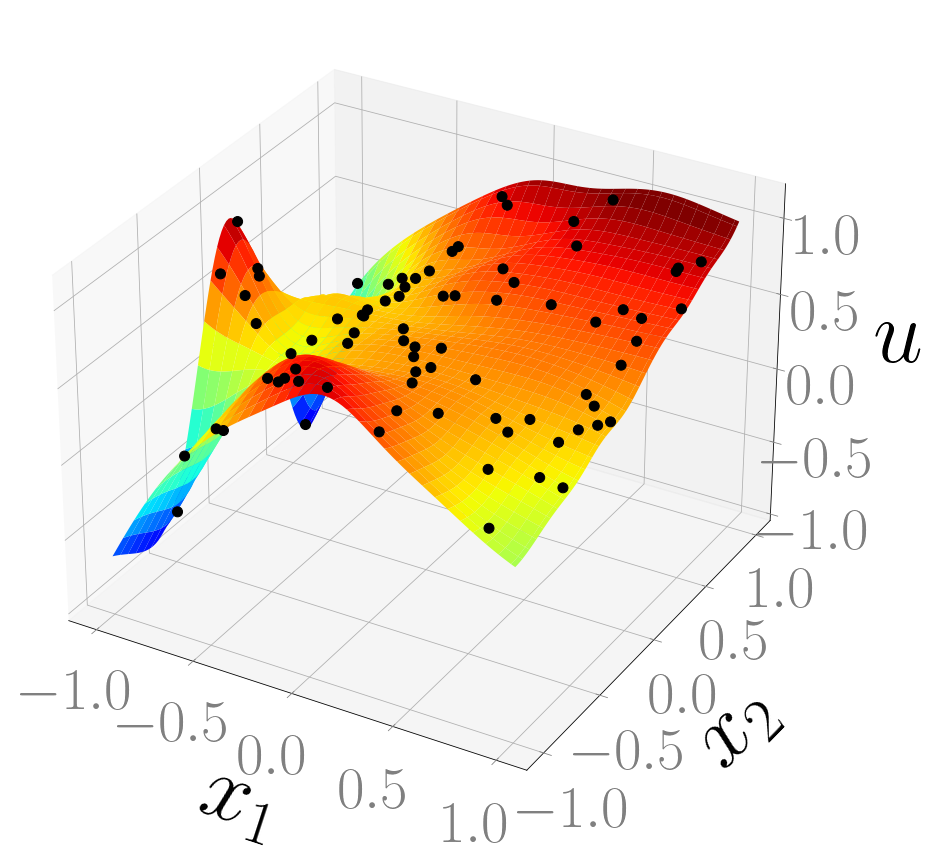

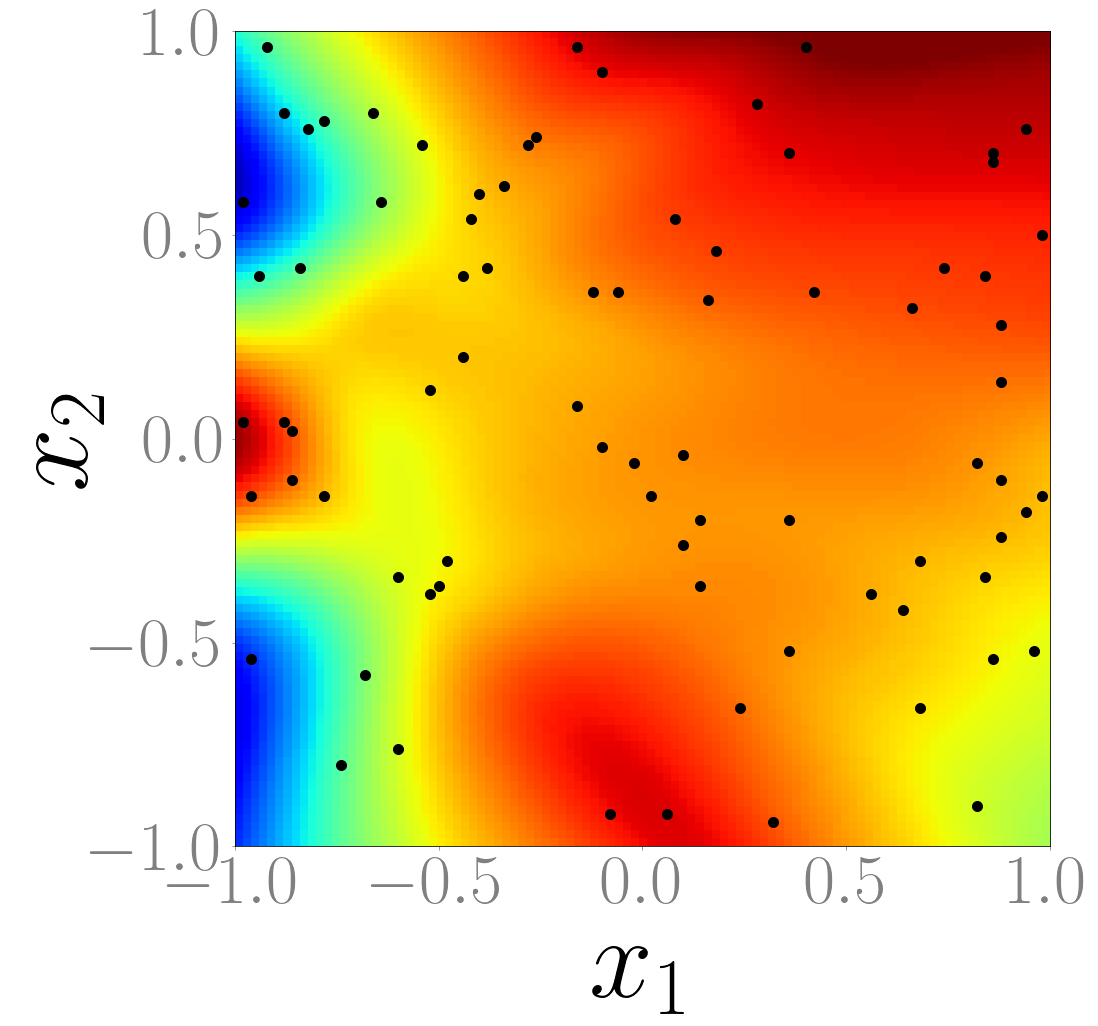

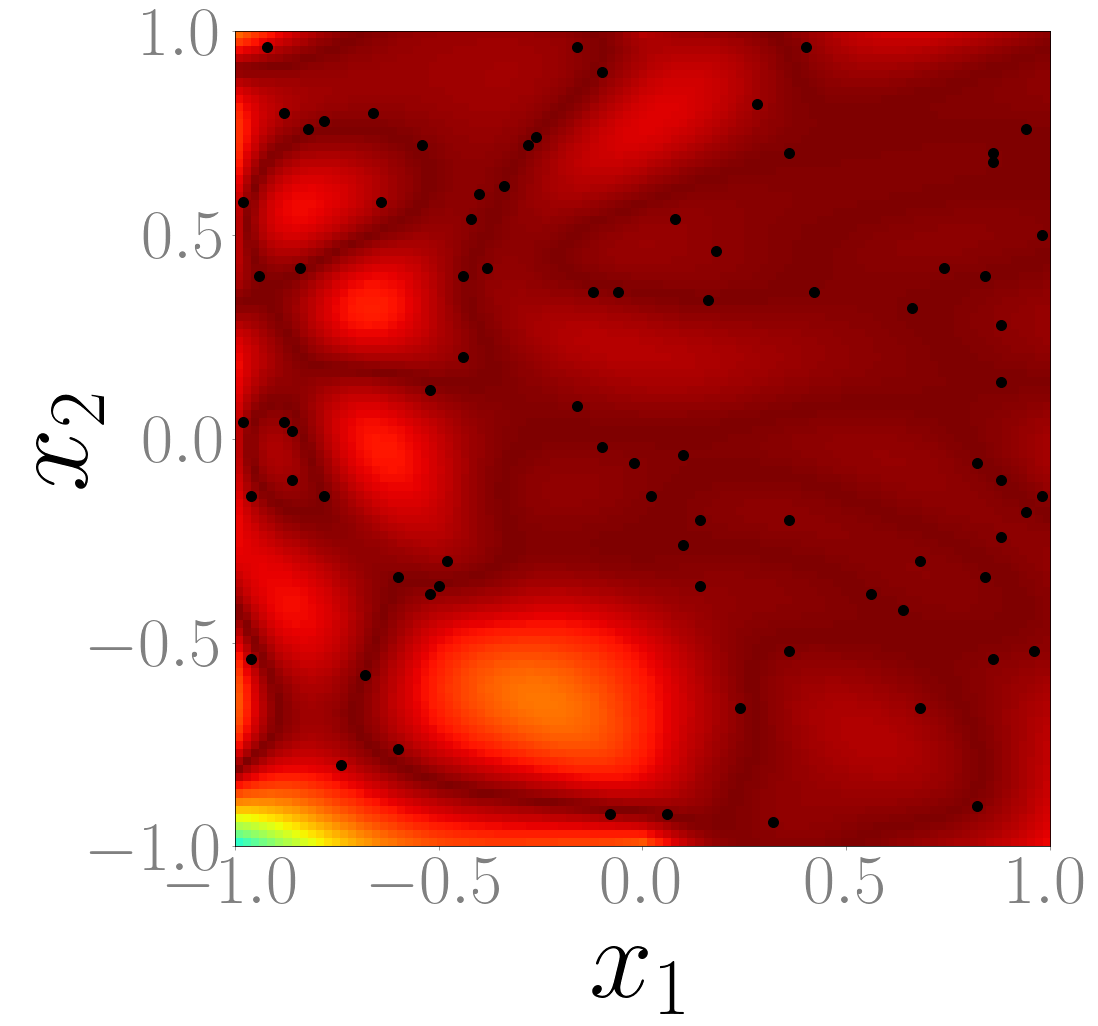

min tensor(6.6757e-06) max tensor(0.6506) mean tensor(0.0391) std tensor(0.0535)


In [10]:
# pinn initialisation
lr = 1e-3 # learning rate
pinn, optimiser, scheduler, mse_loss = initialise_pinn(lr)
    
iterations = 2_001
lambda_physics = 1e-6 # weighting of physics loss
n = 1000 # number of collocation points
loss_values, pinn = train_pinn(iterations, lambda_physics, n, pinn, optimiser, scheduler, mse_loss)

# Visualize convergence of loss function

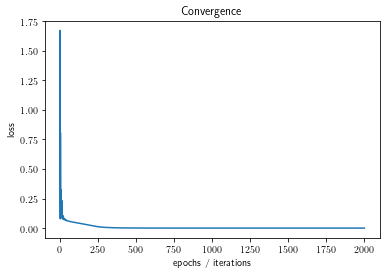

In [11]:
epochs = list(range(1,iterations+1))
fig, ax = plt.subplots()
ax.plot(epochs, loss_values)
ax.set(xlabel='epochs / iterations', 
       ylabel='loss',
       title='Convergence')
#plt.savefig('pinn_loss.jpg', dpi=500, format='jpeg', bbox_inches='tight')
plt.show()